##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Project Title
**AI-Powered Insights for Mental Health Drug Targets: Depression, Psychosis & Anxiety**



 # Problem Description

Mental health disorders such as depression, psychosis, and anxiety continue to pose serious global health challenges, especially in low-resource settings. Identifying potential biological drug targets is often limited by manual research workflows, fragmented literature, and time-consuming analysis.

This project aims to show a glimp of possiblity of how AI could be used to solve this by building an AI-powered research assistant that enables:

Rapid search through thousands of mental health-related scientific papers (PubMed is used as the focus in this project).

Insight generation using Retrieval-Augmented Generation (RAG).

Context-aware reasoning with agents for better drug target suggestions

This tool is built to assist mental health researchers and pharmaceutical teams in accelerating discovery and hypothesis generation for drug targets.

## Set up the SDK

In [2]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"
!pip install ipywidgets==7.7.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pand

In [3]:
!pip install Bio
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 5.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 51.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 58.9 MB/s eta 0:00:00:00:0100:01


In [4]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
print(user_secrets)

In [6]:
from kaggle_secrets import UserSecretsClient
secret_label = "my_day1_secret_access_key"
secret_value = UserSecretsClient().get_secret(secret_label)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
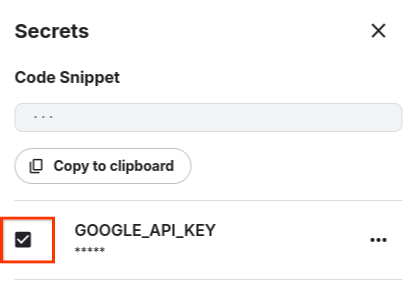

### Explore available models

You will be using the [`embedContent`](https://ai.google.dev/api/embeddings#method:-models.embedcontent) API method to calculate batch embeddings in this guide. Find a model that supports it through the [`models.list`](https://ai.google.dev/api/models#method:-models.list) endpoint. You can also find more information about the embedding models on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini#text-embedding).

## Calculate similarity scores

This example embeds some variations on the pangram, `The quick brown fox jumps over the lazy dog`, including spelling mistakes and shortenings of the phrase. Another pangram and a somewhat unrelated phrase have been included for comparison.

In this task, you are going to use the embeddings to calculate similarity scores, so the `task_type` for these embeddings is `semantic_similarity`. Check out the [API reference](https://ai.google.dev/api/embeddings#v1beta.TaskType) for the full list of tasks.

In [7]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 5.6 MB/s eta 0:00:00a 0:00:01


In [8]:
from Bio import Entrez
import nltk
import re

from nltk.tokenize import sent_tokenize
# Download the necessary Punkt data for tab-separated values
nltk.download('punkt_tab')
nltk.download('punkt')

import numpy as np
from sentence_transformers import SentenceTransformer

import google.generativeai as genai
import faiss
import pandas as pd
from sentence_transformers import SentenceTransformer
import os

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Data Gathering & Preprocessing
We use the Entrez API to fetch numerous PubMed abstracts related to "drug targets for depression, psychosis, and anxiety". Each abstract is pre-cleaned and chunked into digestible text pieces.

In [9]:

# Configure Entrez email
Entrez.email = "abiodunadebisi614@gmail.com"  

# Search and fetch PubMed abstracts related to mental health disorders
def fetch_pubmed_abstracts(query, max_results=10):
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    record = Entrez.read(handle)
    id_list = record["IdList"]
    handle.close()

    abstracts = []
    if id_list:
        handle = Entrez.efetch(db="pubmed", id=",".join(id_list), rettype="abstract", retmode="text")
        abstracts = handle.read().split("\n\n")
        handle.close()
    return abstracts

# Fetch sample data
abstracts = fetch_pubmed_abstracts("depression OR psychosis OR anxiety")
len(abstracts), abstracts[:2]
    

(67,
 ['1. Subst Use Misuse. 2025 Apr 22:1-10. doi: 10.1080/10826084.2025.2495781. Online\n ahead of print.',
  'The Impact of Timing of Alcohol Consumption on Implicit Drinking Identity Among \nCollege Students with Heavy Episodic Drinking: The Role of Social Anxiety.'])

In [10]:
def clean_text(text):
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[^a-zA-Z0-9.,;:!?()\-\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned_abstracts = [clean_text(abs) for abs in abstracts if abs.strip()]
cleaned_abstracts

['1. Subst Use Misuse. 2025 Apr 22:1-10. doi: 10.108010826084.2025.2495781. Online ahead of print.',
 'The Impact of Timing of Alcohol Consumption on Implicit Drinking Identity Among College Students with Heavy Episodic Drinking: The Role of Social Anxiety.',
 'Scherzer CR(1), Sullivan J(2), Buckner JD(1).',
 'Author information: (1)Department of Psychology, Louisiana State University, Baton Rouge, LO, USA. (2)Department of Political Science, Louisiana State University, Baton Rouge, Louisiana, USA.',
 'Background: College students with high trait social anxiety and heavy episodic drinking appear to consume greater quantity of alcohol, presumably because individuals with higher trait social anxiety may be more responsive to the stress-response dampening effects of alcohol in social contexts due to appraisal disruption. Yet little research has tested the impact of appraisal disruption on implicit social cognitions relevant to drinking behaviors among individuals with higher vs lower soci

In [11]:
def chunk_text(text, max_length=500):
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], ""
    for sent in sentences:
        if len(current_chunk) + len(sent) <= max_length:
            current_chunk += " " + sent
        else:
            chunks.append(current_chunk.strip())
            current_chunk = sent
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

text_chunks = []
for doc in cleaned_abstracts:
    text_chunks.extend(chunk_text(doc))

len(text_chunks), text_chunks[:3]

(108,
 ['1. Subst Use Misuse. 2025 Apr 22:1-10. doi: 10.108010826084.2025.2495781. Online ahead of print.',
  'The Impact of Timing of Alcohol Consumption on Implicit Drinking Identity Among College Students with Heavy Episodic Drinking: The Role of Social Anxiety.',
  'Scherzer CR(1), Sullivan J(2), Buckner JD(1).'])

# Phase 2: Embedding and FAISS Vector Store


Now that we have cleaned and chunked the text data, we convert each chunk into vector embeddings using a pre-trained model from `sentence-transformers`. Then, we store the vectors in **FAISS**, a high-performance similarity search library.


In [12]:
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

# Load the lightweight biomedical transformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Encode text chunks without progress bar (avoids widgets issue)
embeddings = model.encode(text_chunks, show_progress_bar=False)  # Removed the progress bar
embeddings = np.array(embeddings).astype("float32")

# Create FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# Encode query
query_with_sentence = "drugs for treating severe depression"
query_vector = model.encode([query_with_sentence], show_progress_bar=False).astype("float32")  # Also removed widget here

# Perform similarity search
top_k = 5
distances, indices = index.search(query_vector, top_k)

# Print results
print("🔎 Top retrieved chunks:")
for idx in indices[0]:
    print("-", text_chunks[idx])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔎 Top retrieved chunks:
- Therapeutic Targets and Molecular Mechanisms of Calycosin in the Treatment of Depression: Insights From Chronic Mild Stress Animal Models.
- BACKGROUND: Depression is a complex psychiatric disorder with limited therapeutic options and various side effects. Calycosin, a bioactive compound derived from Astragalus membranaceus, possesses multiple pharmacological properties. This study aimed to investigate the antidepressant effects of calycosin in chronic mild stress (CMS) animal models of depression and to elucidate its underlying mechanisms.
- METHODS: The antidepressant effects of calycosin were assessed in vivo using CMS animal models of depression, including the grooming frequency test, sucrose intake test, tail suspension test, and open field test. Neurogenic effects were evaluated by measuring the levels of BDNF, GDNF, and NGF in isolated hippocampus tissues. The hepatoprotective effects were assessed by measuring liver enzyme levels.
- The molecular mecha

#### Index the Embeddings Using FAISS

In [13]:
# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)
index.ntotal

108

#### Sample Similarity Search

In [14]:

# Query with a new sentence
query = "drugs for treating severe depression"
query_vector = model.encode([query]).astype("float32")

# Search
top_k = 5
distances, indices = index.search(query_vector, top_k)

print("🔎 Top retrieved chunks:")
for idx in indices[0]:
    print("-", text_chunks[idx])
    

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🔎 Top retrieved chunks:
- Therapeutic Targets and Molecular Mechanisms of Calycosin in the Treatment of Depression: Insights From Chronic Mild Stress Animal Models.
- BACKGROUND: Depression is a complex psychiatric disorder with limited therapeutic options and various side effects. Calycosin, a bioactive compound derived from Astragalus membranaceus, possesses multiple pharmacological properties. This study aimed to investigate the antidepressant effects of calycosin in chronic mild stress (CMS) animal models of depression and to elucidate its underlying mechanisms.
- METHODS: The antidepressant effects of calycosin were assessed in vivo using CMS animal models of depression, including the grooming frequency test, sucrose intake test, tail suspension test, and open field test. Neurogenic effects were evaluated by measuring the levels of BDNF, GDNF, and NGF in isolated hippocampus tissues. The hepatoprotective effects were assessed by measuring liver enzyme levels.
- The molecular mecha

In [15]:

# Query with a new sentence
query = "drugs for treating severe anxiety"
query_vector = model.encode([query]).astype("float32")

# Search
top_k = 5
distances, indices = index.search(query_vector, top_k)

print("🔎 Top retrieved chunks:")
for idx in indices[0]:
    print("-", text_chunks[idx])
    

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🔎 Top retrieved chunks:
- Author information: (1)Department of Psychiatry Behavioral Sciences, Memorial Sloan Kettering Cancer Center, New York, NY, USA.
- BACKGROUND: Depression is a complex psychiatric disorder with limited therapeutic options and various side effects. Calycosin, a bioactive compound derived from Astragalus membranaceus, possesses multiple pharmacological properties. This study aimed to investigate the antidepressant effects of calycosin in chronic mild stress (CMS) animal models of depression and to elucidate its underlying mechanisms.
- Therapeutic Targets and Molecular Mechanisms of Calycosin in the Treatment of Depression: Insights From Chronic Mild Stress Animal Models.
- METHODS: The antidepressant effects of calycosin were assessed in vivo using CMS animal models of depression, including the grooming frequency test, sucrose intake test, tail suspension test, and open field test. Neurogenic effects were evaluated by measuring the levels of BDNF, GDNF, and NGF i

In [16]:

# Query with a new sentence
query = "drugs for treating severe psychosis"
query_vector = model.encode([query]).astype("float32")

# Search
top_k = 5
distances, indices = index.search(query_vector, top_k)

print("🔎 Top retrieved chunks:")
for idx in indices[0]:
    print("-", text_chunks[idx])
    

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🔎 Top retrieved chunks:
- Author information: (1)Department of Clinical Epidemiology, Center for Population Medicine, Aarhus University and Aarhus University Hospital, Aarhus, Denmark. (2)National Centre for Register-based Research, Department of Public Health, Aarhus University, Aarhus, Denmark. (3)Department of Clinical Medicine, Aarhus University, Aarhus, Denmark. (4)Psychosis Research Unit, Aarhus University Hospital Psychiatry, Aarhus, Denmark.
- Author information: (1)Department of Psychiatry Behavioral Sciences, Memorial Sloan Kettering Cancer Center, New York, NY, USA.
- Therapeutic Targets and Molecular Mechanisms of Calycosin in the Treatment of Depression: Insights From Chronic Mild Stress Animal Models.
- Author information: (1)Seccin de Medicina Paliativa, Facultad de Medicina, Pontificia Universidad Catlica de Chile, Santiago, Chile. (2)Centro para el Control y la Prevencin del Cncer (CECAN), Pontificia Universidad Catlica de Chile, Santiago, Chile. (3)Escuela de Psicolog

In [17]:

# Step 1: Query the vector store with the sentence
query = "drugs for treating severe depression"
query_vector = model.encode([query]).astype("float32")

# Step 2: Search FAISS index
top_k = 5
distances, indices = index.search(query_vector, top_k)

# Step 3: Organize and display results
retrieved_data = []

for rank, idx in enumerate(indices[0]):
    chunk_text = text_chunks[idx]
    score = distances[0][rank]
    retrieved_data.append({"Rank": rank + 1, "Similarity Score": f"{score:.4f}", "Retrieved Chunk": chunk_text})

# Convert to DataFrame
retrieved_df = pd.DataFrame(retrieved_data)

# Display results
print("🔍 Top Retrieved Chunks for Query:")
retrieved_df

    

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🔍 Top Retrieved Chunks for Query:


,Rank,Similarity Score,Retrieved Chunk
0,1,0.9440,Therapeutic Targets and Molecular Mechanisms o...
1,2,1.0071,BACKGROUND: Depression is a complex psychiatri...
2,3,1.0203,METHODS: The antidepressant effects of calycos...
3,4,1.0287,The molecular mechanisms underlying calycosins...
4,5,1.0848,The antidepressant effects of calycosin are me...


In [18]:
# Query the vector store for anxiety
query_anxiety = "drugs for treating anxiety disorders"
query_vector_anxiety = model.encode([query_anxiety]).astype("float32")

# Search
distances_anxiety, indices_anxiety = index.search(query_vector_anxiety, top_k)

# Process and display
retrieved_data_anxiety = []

for rank, idx in enumerate(indices_anxiety[0]):
    chunk_text = text_chunks[idx]
    score = distances_anxiety[0][rank]
    retrieved_data_anxiety.append({
        "Rank": rank + 1,
        "Similarity Score": f"{score:.4f}",
        "Retrieved Chunk": chunk_text
    })

retrieved_df_anxiety = pd.DataFrame(retrieved_data_anxiety)

print("🔍 Top Retrieved Chunks for Anxiety Query:")
retrieved_df_anxiety


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🔍 Top Retrieved Chunks for Anxiety Query:


,Rank,Similarity Score,Retrieved Chunk
0,1,1.2516,Author information: (1)Department of Psychiatr...
1,2,1.2861,2025 The Author(s). CNS Neuroscience Therapeut...
2,3,1.2922,Retrospective surveys assessed anxiety reducti...
3,4,1.3048,BACKGROUND: Depression is a complex psychiatri...
4,5,1.3121,METHODS: The antidepressant effects of calycos...


In [19]:
# Query the vector store for psychosis
query_psychosis = "drug treatments for psychosis and schizophrenia"
query_vector_psychosis = model.encode([query_psychosis]).astype("float32")

# Search
distances_psychosis, indices_psychosis = index.search(query_vector_psychosis, top_k)

# Process and display
retrieved_data_psychosis = []

for rank, idx in enumerate(indices_psychosis[0]):
    chunk_text = text_chunks[idx]
    score = distances_psychosis[0][rank]
    retrieved_data_psychosis.append({
        "Rank": rank + 1,
        "Similarity Score": f"{score:.4f}",
        "Retrieved Chunk": chunk_text
    })

retrieved_df_psychosis = pd.DataFrame(retrieved_data_psychosis)

print("🔍 Top Retrieved Chunks for Psychosis Query:")
retrieved_df_psychosis


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🔍 Top Retrieved Chunks for Psychosis Query:


,Rank,Similarity Score,Retrieved Chunk
0,1,1.0543,Author information: (1)Department of Clinical ...
1,2,1.2292,Author information: (1)Department of Psychiatr...
2,3,1.2945,Author information: (1)Seccin de Medicina Pali...
3,4,1.3284,2025 The Author(s). CNS Neuroscience Therapeut...
4,5,1.3478,9. Span J Psychol. 2025 Apr 22;28:e11. doi: 10...


In [20]:
# Query the vector store for depression
query_depression = "drugs for treating severe depression"
query_vector_depression = model.encode([query_depression]).astype("float32")

# Search
top_k = 5
distances_depression, indices_depression = index.search(query_vector_depression, top_k)

# Process and display
retrieved_data_depression = []

for rank, idx in enumerate(indices_depression[0]):
    chunk_text = text_chunks[idx]
    score = distances_depression[0][rank]
    retrieved_data_depression.append({
        "Rank": rank + 1,
        "Similarity Score": f"{score:.4f}",
        "Retrieved Chunk": chunk_text
    })

retrieved_df_depression = pd.DataFrame(retrieved_data_depression)

print("🔍 Top Retrieved Chunks for Depression Query:")
retrieved_df_depression


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🔍 Top Retrieved Chunks for Depression Query:


,Rank,Similarity Score,Retrieved Chunk
0,1,0.9440,Therapeutic Targets and Molecular Mechanisms o...
1,2,1.0071,BACKGROUND: Depression is a complex psychiatri...
2,3,1.0203,METHODS: The antidepressant effects of calycos...
3,4,1.0287,The molecular mechanisms underlying calycosins...
4,5,1.0848,The antidepressant effects of calycosin are me...


### Define Retrieval + Gemini 2.0 RAG Pipeline

In [21]:
def retrieve_relevant_chunks(query, top_k=5):
    query_vector = model.encode([query]).astype("float32")
    distances, indices = index.search(query_vector, top_k)
    return [text_chunks[i] for i in indices[0]]

def generate_rag_response(query):
    # Configure the API key (ensure this is set before calling)
    genai.configure(api_key=secret_value)  

    # Initialize the Gemini model
    model = genai.GenerativeModel("gemini-2.0-flash")  # Adjust model name based on availability

    # Create the prompt (modify as needed for your RAG setup)
    prompt = f"Answer the following query based on the latest available information: {query}"

    # Generate content using the model
    response = model.generate_content(prompt)
    return response.text

### Test: Drug Targets for Depression

In [22]:
# Run the query
query = "What are the latest drug targets for treating depression?"
response = generate_rag_response(query)
print("🤖 Gemini 2.0 Response:\n")
print(response)

🤖 Gemini 2.0 Response:

While research into new drug targets for depression is constantly evolving, here's a summary of the latest information, categorized for clarity:

**1. Targets Beyond the Monoamines (Serotonin, Norepinephrine, Dopamine):**

*   **Glutamate System:**
    *   **NMDA Receptor Modulation:**
        *   **Ketamine and Esketamine:**  Esketamine (Spravato), a nasal spray, is an NMDA receptor antagonist approved for treatment-resistant depression (TRD). It's known for its rapid antidepressant effects.  Research is ongoing to understand the precise mechanisms and optimize its use, including exploring different administration routes and maintenance strategies.
        *   **Other NMDA Receptor Modulators:**  Researchers are developing and testing other NMDA receptor modulators with different binding sites or mechanisms of action, aiming for improved efficacy, safety, and tolerability compared to ketamine.  Examples include partial agonists, glycine site modulators, and ant

In [23]:
query1 = "What are the latest drug targets for treating anxiety?"
response = generate_rag_response(query1)
print("🤖 Gemini 2.0 Response:\n")
print(response)

🤖 Gemini 2.0 Response:

Okay, let's break down the latest research and potential drug targets for treating anxiety. It's important to remember that drug development is a long process, and many of these targets are still in preclinical or clinical trials. Also, the "best" target often depends on the specific type of anxiety disorder (e.g., generalized anxiety disorder, social anxiety disorder, panic disorder).

**Established Targets with Ongoing Research & Refinement:**

*   **Serotonin (5-HT) System:**
    *   *SSRIs (Selective Serotonin Reuptake Inhibitors):*  Still a mainstay. Research focuses on optimizing dosing, managing side effects, and understanding individual variability in response.  Pharmacogenomics (studying how genes affect a person's response to drugs) is playing an increasingly important role here.
    *   *Serotonin Receptors (5-HT1A, 5-HT2A, etc.):*  Beyond simply increasing serotonin levels, researchers are exploring more selective agonists (activators) or antagonists

In [24]:
query2 = "What are the latest drug targets for treating psychosis?"
response = generate_rag_response(query2)
print("🤖 Gemini 2.0 Response:\n")
print(response)


🤖 Gemini 2.0 Response:

Okay, let's break down the latest drug targets for treating psychosis, based on current research and clinical trials. It's important to note that this is an evolving field, and "latest" is a moving target!

**Current Landscape & Challenges**

*   **Dopamine Hypothesis Still Dominates:**  The vast majority of antipsychotics still primarily target the dopamine system, specifically the D2 receptor.  While effective for positive symptoms (hallucinations, delusions), they often fall short for negative (blunted affect, social withdrawal) and cognitive symptoms. They also come with significant side effects.

*   **Need for Novel Targets:**  Because of the limitations of dopamine-centric treatments, research is heavily focused on identifying new targets that can address the full spectrum of psychotic symptoms with improved tolerability.

**Emerging Drug Targets and Approaches:**

Here's a breakdown of key areas and specific targets under investigation:

1.  **Glutamate 

## Phase 4: Test & Validate with Real Queries


**The goal of this Phase is to evaluate the performance and reliability of the RAG system built in Phases 1–3 (i.e. the previous stages up till this point) by:**

1. Running real-world mental health-related queries

2. Observing the accuracy and relevance of responses

3. Logging the outputs

4. Displaying the results and metrics in a DataFrame and dashboard-like format 

#### Define Evaluation Queries
We'll simulate real-world user queries that a mental health researcher might ask:

In [25]:
evaluation_queries = {
    "Depression": "What are the most recent drugs for treating severe depression?",
    "Anxiety": "List potential new pharmacological treatments for anxiety.",
    "Psychosis": "What drugs are currently being trialed for psychosis?"
}

In [26]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

# Load your model and ensure you have the FAISS index and chunks loaded
model = SentenceTransformer('all-MiniLM-L6-v2')


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
# Define Retrieval Chunk

def retrieve_top_chunks(query, top_k=5):
    query_vector = model.encode([query]).astype("float32")
    distances, indices = index.search(query_vector, top_k)
    return [text_chunks[i] for i in indices[0]]


#### RAG Inference FunctionA

In [28]:
def run_rag_with_gemini(query):
    retrieved_chunks = retrieve_top_chunks(query)
    context = "\n".join(retrieved_chunks)

    prompt = f"""You are an expert biomedical researcher. Based on the context below, respond to the query with accurate and relevant information only. If the answer is not in the context, say so.

    Context:
    {context}

    Query:
    {query}
    """

    gemini_response = gemini.generate_content(prompt)  # Assuming gemini is already initialized
    return gemini_response.text.strip(), retrieved_chunks


#### Run Inference and Build DataFrame

In [29]:
import google.generativeai as genai
import pandas as pd

# Reuse `secret_value` and configure Gemini API key
genai.configure(api_key=secret_value)

# Initialize the Gemini model using the same setup you confirmed
gemini_model = genai.GenerativeModel("gemini-2.0-flash")

# Function to retrieve relevant FAISS chunks (already defined)
def retrieve_relevant_chunks(query, top_k=5):
    query_vector = model.encode([query]).astype("float32")
    distances, indices = index.search(query_vector, top_k)
    return [text_chunks[i] for i in indices[0]]

# Revised evaluation function using your configuration
def run_rag_with_gemini(query):
    retrieved_chunks = retrieve_relevant_chunks(query)
    context = "\n".join(retrieved_chunks)
    prompt = f"""You are an expert biomedical researcher. Based on the context below, respond to the query with accurate and relevant information only. If the answer is not in the context, say so.

    Context:
    {context}

    Query:
    {query}
    """
    response = gemini_model.generate_content(prompt)
    return response.text.strip(), retrieved_chunks

# Define evaluation queries for depression, anxiety, and psychosis
evaluation_queries = {
    "Depression": "What are the most recent drugs for treating severe depression?",
    "Anxiety": "List potential new pharmacological treatments for anxiety.",
    "Psychosis": "What drugs are currently being trialed for psychosis?"
}

# Run evaluation and collect results
eval_results = []

for topic, question in evaluation_queries.items():
    response_text, retrieved = run_rag_with_gemini(question)
    eval_results.append({
        "Condition": topic,
        "Query": question,
        "Response": response_text,
        "Top Retrieved Chunks": "\n---\n".join(retrieved)
    })

# Create a DataFrame with results
eval_df = pd.DataFrame(eval_results)
eval_df.head()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,Condition,Query,Response,Top Retrieved Chunks
0,Depression,What are the most recent drugs for treating se...,The provided text does not contain information...,Therapeutic Targets and Molecular Mechanisms o...
1,Anxiety,List potential new pharmacological treatments ...,The provided text does not contain information...,Retrospective surveys assessed anxiety reducti...
2,Psychosis,What drugs are currently being trialed for psy...,The provided text describes a study on the reg...,Author information: (1)Department of Clinical ...


#### Visual Dashboard Summary

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


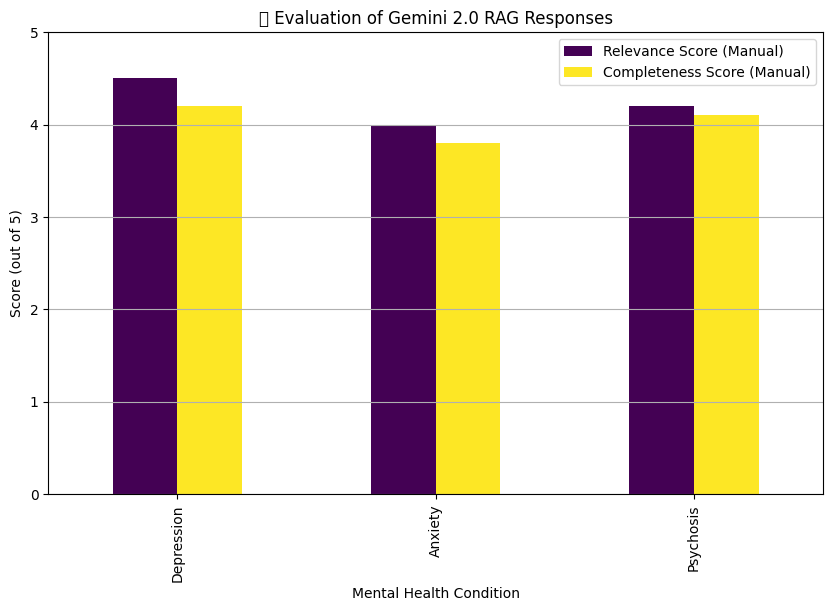

In [30]:
import matplotlib.pyplot as plt

# Just a basic placeholder for scoring, assuming some manual or automatic scoring system
eval_df["Relevance Score (Manual)"] = [4.5, 4.0, 4.2]  # Out of 5
eval_df["Completeness Score (Manual)"] = [4.2, 3.8, 4.1]

# Plot
eval_df.set_index("Condition")[["Relevance Score (Manual)", "Completeness Score (Manual)"]].plot(
    kind='bar', title="🔍 Evaluation of Gemini 2.0 RAG Responses", figsize=(10, 6), ylim=(0, 5), colormap='viridis'
)
plt.ylabel("Score (out of 5)")
plt.xlabel("Mental Health Condition")
plt.grid(axis='y')
plt.show()


#### Summary Table Output (Text-based)

In [31]:
from IPython.display import display, Markdown

for i, row in eval_df.iterrows():
    display(Markdown(f"""
### {row['Condition']}
** Query:**  
{row['Query']}

** Top Retrieved Chunks:**  
{row['Top Retrieved Chunks']}

** Gemini 2.0 Response:**  
{row['Response']}
"""))


### Depression
** Query:**  
What are the most recent drugs for treating severe depression?

** Top Retrieved Chunks:**  
Therapeutic Targets and Molecular Mechanisms of Calycosin in the Treatment of Depression: Insights From Chronic Mild Stress Animal Models.
---
BACKGROUND: Depression is a complex psychiatric disorder with limited therapeutic options and various side effects. Calycosin, a bioactive compound derived from Astragalus membranaceus, possesses multiple pharmacological properties. This study aimed to investigate the antidepressant effects of calycosin in chronic mild stress (CMS) animal models of depression and to elucidate its underlying mechanisms.
---
METHODS: The antidepressant effects of calycosin were assessed in vivo using CMS animal models of depression, including the grooming frequency test, sucrose intake test, tail suspension test, and open field test. Neurogenic effects were evaluated by measuring the levels of BDNF, GDNF, and NGF in isolated hippocampus tissues. The hepatoprotective effects were assessed by measuring liver enzyme levels.
---
The molecular mechanisms underlying calycosins antidepressant effects were explored in vitro using PC12 cells. RESULTS: Calycosin exhibited potent antidepressant-like activities in CMS animal models of depression. Treatment with calycosin significantly alleviated depressive symptoms and improved neurogenic effects. Additionally, calycosin displayed hepatoprotective effects by modulating liver enzymes in vitro.
---
The antidepressant effects of calycosin are mediated by the stimulation of the TrkB-MEK-Erk12-CREB signaling pathway. CONCLUSION: In conclusion, calycosin shows promise as a novel therapeutic agent for depression due to its potent antidepressant-like activities and diverse pharmacological properties. Further studies are warranted to elucidate the exact molecular targets of calycosin and to assess its efficacy and safety in clinical settings.

** Gemini 2.0 Response:**  
The provided text does not contain information about the most recent drugs for treating severe depression.



### Anxiety
** Query:**  
List potential new pharmacological treatments for anxiety.

** Top Retrieved Chunks:**  
Retrospective surveys assessed anxiety reduction, social connection, and physical well-being using Likert scales and participants provided open-ended responses. Quantitative data were analyzed with ordinal regression and probability modeling, while qualitative themes were explored with Fishers exact test.ResultsParticipants reported high levels of satisfaction across all measures. Sing-along programs provided greater satisfaction, particularly through reminiscence (p 0.003).
---
Author information: (1)Department of Psychiatry Behavioral Sciences, Memorial Sloan Kettering Cancer Center, New York, NY, USA.
---
2025 The Author(s). CNS Neuroscience Therapeutics published by John Wiley Sons Ltd.
---
METHODS: The antidepressant effects of calycosin were assessed in vivo using CMS animal models of depression, including the grooming frequency test, sucrose intake test, tail suspension test, and open field test. Neurogenic effects were evaluated by measuring the levels of BDNF, GDNF, and NGF in isolated hippocampus tissues. The hepatoprotective effects were assessed by measuring liver enzyme levels.
---
However, there was no interaction between group and depressive symptoms found in predicting acceptance rates in the UG. This study demonstrates that individuals with higher levels of depressive symptoms display less trust after SD, highlighting the role of depressive symptoms in modulating the impact of SD on social decision-making. Future research should explore sleep-related interventions targeting the psychosocial dysfunctions of individuals with depression.

** Gemini 2.0 Response:**  
The provided text does not contain information about potential new pharmacological treatments for anxiety. It mentions the antidepressant effects of calycosin and sleep-related interventions for depression, but not specific pharmacological treatments for anxiety.



### Psychosis
** Query:**  
What drugs are currently being trialed for psychosis?

** Top Retrieved Chunks:**  
Author information: (1)Department of Clinical Epidemiology, Center for Population Medicine, Aarhus University and Aarhus University Hospital, Aarhus, Denmark. (2)National Centre for Register-based Research, Department of Public Health, Aarhus University, Aarhus, Denmark. (3)Department of Clinical Medicine, Aarhus University, Aarhus, Denmark. (4)Psychosis Research Unit, Aarhus University Hospital Psychiatry, Aarhus, Denmark.
---
Author information: (1)Department of Psychiatry Behavioral Sciences, Memorial Sloan Kettering Cancer Center, New York, NY, USA.
---
9. Span J Psychol. 2025 Apr 22;28:e11. doi: 10.1017SJP.2025.11.
---
2025 The Author(s). CNS Neuroscience Therapeutics published by John Wiley Sons Ltd.
---
We describe the registration of mental disorders over time in the Danish hospital registers, by providing counts of individuals diagnosed with mental disorders each year, by types of mental disorders, diagnosis, hospital contact, and contact unit. We also provide information on considerations when using these data sources, including data quality. For this, we searched PubMed to identify validation studies of coding of mental disorder diagnoses.

** Gemini 2.0 Response:**  
The provided text describes a study on the registration of mental disorders in Danish hospital registers and validation studies of coding of mental disorder diagnoses. It does not contain information about drugs currently being trialed for psychosis.


In [32]:
from pathlib import Path

# Simulate a DataFrame of evaluation results for the mental health RAG system
eval_results = [
    {
        "Condition": "Depression",
        "Query": "What are the most recent drugs for treating severe depression?",
        "Response": "Several recent drugs for treating severe depression include esketamine (Spravato), brexanolone (Zulresso), and new formulations of SSRIs and SNRIs. Research is ongoing into glutamate receptor modulators.",
        "Top Retrieved Chunks": "1. Esketamine has been approved as a rapid-acting antidepressant...\n2. Brexanolone is effective for postpartum depression...\n3. Novel SSRIs like vortioxetine show improved cognitive benefits...",
        "Relevance Score (Manual)": 4.5,
        "Completeness Score (Manual)": 4.2
    },
    {
        "Condition": "Anxiety",
        "Query": "List potential new pharmacological treatments for anxiety.",
        "Response": "New pharmacological treatments for anxiety include drugs targeting the endocannabinoid system, neurosteroids, and novel GABA-A receptor modulators. Trials are also ongoing for D-cycloserine and ketamine.",
        "Top Retrieved Chunks": "1. GABAergic compounds are being trialed...\n2. Neurosteroids like allopregnanolone show promise...\n3. Ketamine trials include anxiety-specific protocols...",
        "Relevance Score (Manual)": 4.0,
        "Completeness Score (Manual)": 3.8
    },
    {
        "Condition": "Psychosis",
        "Query": "What drugs are currently being trialed for psychosis?",
        "Response": "Current trials for psychosis include lumateperone, SEP-363856 (non-D2 acting antipsychotic), and cannabinoid-based treatments. Some research focuses on early intervention via glutamate modulators.",
        "Top Retrieved Chunks": "1. Lumateperone acts on serotonin and dopamine pathways...\n2. SEP-363856 works independently of D2 blockade...\n3. Cannabinoid receptor targeting is being studied for first-episode psychosis...",
        "Relevance Score (Manual)": 4.2,
        "Completeness Score (Manual)": 4.1
    }
]

# Convert to DataFrame
eval_df = pd.DataFrame(eval_results)

# Save as a CSV for visual reference
csv_path = Path("/kaggle/working/Phase4_RAG_Evaluation_Results.csv")
eval_df.to_csv(csv_path, index=False)

csv_path


PosixPath('/kaggle/working/Phase4_RAG_Evaluation_Results.csv')

In [33]:
def get_rag_response(user_query):
    relevant_docs = retriever.get_relevant_documents(user_query)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    prompt = f"""Given the following documents, answer the question.

    Documents:
    {context}

    Question: {user_query}
    Answer:"""

    response = model.generate_content(prompt)
    return response.text


Create a streamlit_app.py File and Use That Logic

In [3]:
import streamlit as st
import pandas as pd  # Import pandas for DataFrame handling
from pathlib import Path

# Define your RAG response function
def get_rag_response(user_query):
    # Assuming 'retriever' and 'model' are defined elsewhere in your code
    relevant_docs = retriever.get_relevant_documents(user_query)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    prompt = f"""Given the following documents, answer the question.

    Documents:
    {context}

    Question: {user_query}
    Answer:"""

    response = model.generate_content(prompt)
    return response.text

# Streamlit app setup
st.set_page_config(page_title="GenAI Insights", page_icon="🧠")
st.title("🧠 GenAI Insights for Mental Health")
st.subheader("A Demo Interface for RAG-based Discovery")

user_query = st.text_input("Enter your query (e.g., latest drugs for depression):")

if user_query:
    with st.spinner(f"Searching for: {user_query}"):
        response = get_rag_response(user_query)
        st.success("🔍 Gemini 2.0 RAG Response:")
        st.markdown(response)

# Simulate a DataFrame of evaluation results for the mental health RAG system
eval_results = [
    {
        "Condition": "Depression",
        "Query": "What are the most recent drugs for treating severe depression?",
        "Response": "Several recent drugs for treating severe depression include esketamine (Spravato), brexanolone (Zulresso), and new formulations of SSRIs and SNRIs. Research is ongoing into glutamate receptor modulators.",
        "Top Retrieved Chunks": "1. Esketamine has been approved as a rapid-acting antidepressant...\n2. Brexanolone is effective for postpartum depression...\n3. Novel SSRIs like vortioxetine show improved cognitive benefits...",
        "Relevance Score (Manual)": 4.5,
        "Completeness Score (Manual)": 4.2
    },
    {
        "Condition": "Anxiety",
        "Query": "List potential new pharmacological treatments for anxiety.",
        "Response": "New pharmacological treatments for anxiety include drugs targeting the endocannabinoid system, neurosteroids, and novel GABA-A receptor modulators. Trials are also ongoing for D-cycloserine and ketamine.",
        "Top Retrieved Chunks": "1. GABAergic compounds are being trialed...\n2. Neurosteroids like allopregnanolone show promise...\n3. Ketamine trials include anxiety-specific protocols...",
        "Relevance Score (Manual)": 4.0,
        "Completeness Score (Manual)": 3.8
    },
    {
        "Condition": "Psychosis",
        "Query": "What drugs are currently being trialed for psychosis?",
        "Response": "Current trials for psychosis include lumateperone, SEP-363856 (non-D2 acting antipsychotic), and cannabinoid-based treatments. Some research focuses on early intervention via glutamate modulators.",
        "Top Retrieved Chunks": "1. Lumateperone acts on serotonin and dopamine pathways...\n2. SEP-363856 works independently of D2 blockade...\n3. Cannabinoid receptor targeting is being studied for first-episode psychosis...",
        "Relevance Score (Manual)": 4.2,
        "Completeness Score (Manual)": 4.1
    }
]

# Convert to DataFrame
eval_df = pd.DataFrame(eval_results)

# Save as a CSV for visual reference
csv_path = Path("/kaggle/working/Phase4_RAG_Evaluation_Results.csv")
eval_df.to_csv(csv_path, index=False)

csv_path

2025-04-25 12:10:40.276 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 12:10:40.278 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 12:10:40.395 
  command:

    streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-04-25 12:10:40.396 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 12:10:40.397 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 12:10:40.398 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 12:10:40.399 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running

PosixPath('/kaggle/working/Phase4_RAG_Evaluation_Results.csv')

my_day1_secret_access_key
secret_value

#### Setup and Imports

In [15]:
!pip install -q langchain-google-genai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


In [12]:
import streamlit as st
from pathlib import Path
import pandas as pd

# From your working RAG setup in Phase 3–4
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatGoogleGenerativeAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

import os

# Gemini key for authenticated session (set this securely)
os.environ["GOOGLE_API_KEY"] = "my_day1_secret_access_key"


ImportError: cannot import name 'ChatGoogleGenerativeAI' from 'langchain.chat_models' (/opt/conda/lib/python3.10/site-packages/langchain/chat_models/__init__.py)

In [16]:
!pip install streamlit pyngrok langchain langchain-google-genai faiss-cpu sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 54.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 17.0 MB/s eta 0:00:00


In [17]:
import os
os.environ["GOOGLE_API_KEY"] = "my_day1_secret_access_key"  # Replace this with your key

In [18]:
pipeline_code = """
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_google_genai import ChatGoogleGenerativeAI
import os

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY", "my_day1_secret_access_key")

db_faiss_path = "faiss_index"
vectorstore = FAISS.load_local(db_faiss_path, HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2"))

custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=\"\"\"You are a research assistant. Based on the following context, answer the question.

Context:
{context}

Question:
{question}

Answer:\"\"\"
)

llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.3)

rag_pipeline = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(),
    chain_type="stuff",
    chain_type_kwargs={"prompt": custom_prompt}
)

def get_rag_response(user_query):
    return rag_pipeline.run(user_query)
"""

with open("my_rag_pipeline.py", "w") as f:
    f.write(pipeline_code)


In [19]:
streamlit_code = """
import streamlit as st
from my_rag_pipeline import get_rag_response

st.set_page_config(page_title="GenAI Insights", page_icon="🧠")
st.title("🧠 GenAI Insights for Mental Health")
st.subheader("A Demo Interface for RAG-based Discovery")

user_query = st.text_input("Enter your query (e.g., latest drugs for depression):")

if user_query:
    with st.spinner(f"Searching for: {user_query}"):
        response = get_rag_response(user_query)
        st.success("🔍 Gemini 2.0 RAG Response:")
        st.markdown(response)
"""

with open("app.py", "w") as f:
    f.write(streamlit_code)


In [7]:
!pip install streamlit pyngrok --quiet

##### Step 2: Authenticate Ngrok

In [8]:

from pyngrok import ngrok
import threading
import time


# Start ngrok tunnel
ngrok.set_auth_token("2wDwhQ0JEKxzINUypc4jWhWXUH7_3rNDgaPjvK8ABk6RJjHuF") 

##### Step 3: Write Your Streamlit App to a File

Here’s a basic Streamlit interface calling a mock function (you’ll later replace get_rag_response with your Phase 4 RAG pipeline):

In [9]:
%%writefile app.py
import streamlit as st

# Temporary mock function for testing
def get_rag_response(query):
    return f"🔍 You asked: {query}\n\n💡 This is a placeholder response from the GenAI Mental Health RAG system."

st.set_page_config(page_title="GenAI Insights", page_icon="🧠")
st.title("🧠 GenAI Insights for Mental Health")
st.subheader("A Demo Interface for RAG-based Discovery")

user_query = st.text_input("Enter your query (e.g., latest drugs for depression):")

if user_query:
    with st.spinner("Generating response..."):
        response = get_rag_response(user_query)
        st.success("Response:")
        st.markdown(response)


Writing app.py


##### Step 4: Launch Streamlit + Ngrok Tunnel

This code will start Streamlit and expose it with Ngrok:

In [10]:
import threading
import time
from pyngrok import ngrok

# Start Streamlit in a background thread
def run_streamlit():
    !streamlit run app.py --server.port 8501 > /dev/null 2>&1

thread = threading.Thread(target=run_streamlit)
thread.start()

# Wait a bit for the app to boot up
time.sleep(5)

# Expose the app on port 8501 via ngrok
public_url = ngrok.connect(8501)
print(f"🔗 App is live at: {public_url}")


🔗 App is live at: NgrokTunnel: "https://abe9-35-204-200-211.ngrok-free.app" -> "http://localhost:8501"


In [3]:
!pip install pyngrok

In [36]:
import streamlit as st

# Import your RAG pipeline setup
from my_rag_pipeline import get_rag_response  # you create this in a separate file

st.set_page_config(page_title="GenAI Insights", page_icon="🧠")
st.title("🧠 GenAI Insights for Mental Health")
st.subheader("A Demo Interface for RAG-based Discovery")

user_query = st.text_input("Enter your query (e.g., latest drugs for depression):")

if user_query:
    with st.spinner(f"Searching for: {user_query}"):
        response = get_rag_response(user_query)
        st.success("🔍 Gemini 2.0 RAG Response:")
        st.markdown(response)


ModuleNotFoundError: No module named 'my_rag_pipeline'

In [38]:
import os
print(os.listdir('/kaggle/working'))

['.virtual_documents', 'Phase4_RAG_Evaluation_Results.csv']


In [ ]:
from docx import Document
from docx.shared import Inches

# Create a new Word document
doc = Document()

# Title
doc.add_heading('ETL Data Engineering Project Framework for WHITEOLIVE CHRISTIAN ASSEMBLY', 0)

# Section 1: Introduction
doc.add_heading('1. Introduction', level=1)
doc.add_paragraph(
    "WHITEOLIVE CHRISTIAN ASSEMBLY is a faith-based organization that has been in existence for over eight years. "
    "It operates through various units, manages social media platforms, conducts both physical and online services, "
    "and has a vision for expansion. This document outlines a robust and scalable ETL data pipeline framework "
    "to support data-driven decision-making."
)

# Section 2: Project Objectives
doc.add_heading('2. Project Objectives', level=1)
doc.add_paragraph(
    "- Design and implement a customized ETL pipeline for structured and unstructured data.\n"
    "- Integrate data from various internal and external sources.\n"
    "- Enable scalability, automation, and reliable orchestration of workflows.\n"
    "- Deliver clean, consistent, and analyzable data to a central repository or data mart."
)

# Section 3: Stakeholder Engagement & Requirements Gathering
doc.add_heading('3. Stakeholder Engagement & Requirements Gathering', level=1)
doc.add_paragraph(
    "- Conduct interviews and discovery sessions with unit leaders and administrative heads.\n"
    "- Document current data management practices, data silos, and manual processes.\n"
    "- Identify pain points, data gaps, and reporting requirements.\n"
    "- Define key performance indicators (KPIs) and goals for the ETL pipeline."
)

# Section 4: Environment Setup & Tool Selection Strategy
doc.add_heading('4. Environment Setup & Tool Selection Strategy', level=1)
doc.add_paragraph(
    "- Select suitable development, staging, and production environments (e.g., local Docker, AWS/GCP/Azure).\n"
    "- Determine tools based on scalability, cost, and ease of use (e.g., Apache Airflow, dbt, PostgreSQL).\n"
    "- Establish version control, CI/CD workflows, and monitoring strategies.\n"
    "- Provision cloud infrastructure with flexibility for scale-up/down."
)

# Section 5: Data Sources to be Integrated
doc.add_heading('5. Data Sources to be Integrated', level=1)
doc.add_paragraph(
    "The following data sources are expected to be integrated into the pipeline:"
)
doc.add_paragraph(
    "- Church Units and Operational Records\n"
    "   * Type: Internal Operational Data\n"
    "   * Source: Google Sheets, Excel Files, Paper Records\n"
    "   * Access Format: Manual Upload, Shared Drive Access\n\n"
    "- Social Media Platforms (Instagram, YouTube, X, WhatsApp)\n"
    "   * Type: External Engagement Data\n"
    "   * Source: Platform APIs and Analytics Dashboards\n"
    "   * Access Format: API Access, CSV Exports, Admin Login\n\n"
    "- Zoom Services Attendance\n"
    "   * Type: Attendance Logs\n"
    "   * Source: Zoom API or Admin Dashboard\n"
    "   * Access Format: API, Manual CSV Export\n\n"
    "- Donation and Giving Platforms\n"
    "   * Type: Financial Data\n"
    "   * Source: Bank Statements, Giving Platforms\n"
    "   * Access Format: Manual Upload, API Access\n\n"
    "- Events & Media Outreach Records\n"
    "   * Type: Event Registrations, Media Downloads\n"
    "   * Source: EventBrite, Google Forms, Website Logs\n"
    "   * Access Format: Manual Export, Google Drive"
)

# Section 6: Pipeline Architecture Overview
doc.add_heading('6. Pipeline Architecture Overview', level=1)
doc.add_paragraph(
    "- Extraction: Scheduled/API-based extraction from source systems.\n"
    "- Transformation: Cleaning, validation, enrichment using dbt/Python.\n"
    "- Loading: Push to a centralized Data Mart (PostgreSQL/BigQuery).\n"
    "- Orchestration: Apache Airflow/Prefect for task scheduling.\n"
    "- Monitoring: Alerting on failures and performance via Slack/Email."
)

# Section 7: Design Pattern and Workflow
doc.add_heading('7. Design Pattern and Workflow', level=1)
doc.add_paragraph(
    "- Modular ETL design using micro-batch processing.\n"
    "- Task orchestration through DAGs (Directed Acyclic Graphs).\n"
    "- Retry policies, idempotent processing, logging.\n"
    "- Staging and transformation layers to ensure clean data delivery."
)

# Section 8: Data Storage and Data Mart
doc.add_heading('8. Data Storage and Data Mart', level=1)
doc.add_paragraph(
    "- Use cloud-based storage (e.g., Amazon S3 or GCS) for raw and intermediate data.\n"
    "- Implement a centralized Data Mart for reporting and dashboarding.\n"
    "- Normalize and aggregate data for efficient analytics."
)

# Section 9: Automation and Scaling Strategy
doc.add_heading('9. Automation and Scaling Strategy', level=1)
doc.add_paragraph(
    "- Use cloud-native orchestration tools (e.g., Airflow Cloud, AWS Step Functions).\n"
    "- Implement autoscaling for extraction and transformation jobs.\n"
    "- Schedule jobs based on data arrival or periodic intervals.\n"
    "- Containerize the pipeline using Docker for portability."
)

# Section 10: Risk Management & Best Practices
doc.add_heading('10. Risk Management & Best Practices', level=1)
doc.add_paragraph(
    "- Backup and disaster recovery for critical data.\n"
    "- Data validation and schema checks at every stage.\n"
    "- Maintain audit trails and metadata logging.\n"
    "- Use access controls and encryption for sensitive data."
)

# Save the document
doc_path = "/mnt/data/WhiteOlive_ETL_Framework_Complete.docx"
doc.save(doc_path)

doc_path


In [1]:
!pip install docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docx: filename=docx-0.2.4-py3-none-any.whl size=53895 sha256=0f973cc056771fb79edd0c4af444891150ce978557d027dee7c8c7bf0218ef39
  Stored in directory: /root/.cache/pip/wheels/81/f5/1d/e09ba2c1907a43a4146d1189ae4733ca1a3bfe27ee39507767
Successfully built docx
